In [378]:
import os
import numpy as np
import pydicom
import highdicom as hd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from highdicom.seg import Segmentation
from skimage import measure
from PIL import Image
from scipy import ndimage
from scipy.ndimage import center_of_mass
from skimage.segmentation import flood
from skimage import exposure
import scipy
import io
import utils
import cv2
from scipy.ndimage import median_filter
from scipy.ndimage import label, center_of_mass, binary_closing, binary_fill_holes,binary_opening
from collections import deque
from sklearn.cluster import KMeans
from scipy.ndimage import label
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter



In [379]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CT FILE

In [ ]:
# Carregam tots els arxius DICOM
reference_image_files = glob(os.path.join('0745/10_AP_Ax5.00mm', '*.dcm'))
ct_images = []
for file in reference_image_files:
    ds = pydicom.dcmread(file)
    ct_images.append(ds)

print(f"Number of DICOM files: {len(ct_images)}")

Number of DICOM files: 52


In [411]:
ct_folder = '0745/10_AP_Ax5.00mm'
# 1. Carregam tots els CT slices
ct_files = glob(os.path.join(ct_folder, '*.dcm'))

# Llegim i guardam informació important
ct_slices = []
ct_positions = []

for file in ct_files:
    ds = pydicom.dcmread(file)
    ct_slices.append(ds)
    ct_positions.append(ds.ImagePositionPatient[2])  # Eix Z




# Ordenam els slices pel valor Z
sorted_idx = np.argsort(ct_positions)
ct_slices = [ct_slices[i] for i in sorted_idx]
# Stackam el volum 3D
ct_volume = np.stack([s.pixel_array for s in ct_slices], axis=0)
ct_volume = np.flip(ct_volume, axis=0)  # Invertim l'eix Z per tenir el volum en l'ordre correcte
print(f'CT volume shape: {ct_volume.shape}')

CT volume shape: (52, 512, 512)


## LIVER

In [412]:
seg_liver = pydicom.dcmread("0745/10_AP_Ax5.00mm_ManualROI_Liver.dcm")

segmentation_mask_liver = []
for i in range(seg_liver.NumberOfFrames):
    frame = seg_liver.PerFrameFunctionalGroupsSequence[i]
    image_position = frame.PlanePositionSequence[0].ImagePositionPatient
    segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    referenced_frame = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber
    mask = seg_liver.pixel_array[i]
    segmentation_mask_liver.append({
        'position': image_position,
        'segment_number': segment_number,
        'mask': mask,
        'referenced_frame': referenced_frame
    })

# Ordenar los frames por posición Z si lo necesitas (opcional si usas ReferencedFrameNumber)
segmentation_masks_live_sorted = sorted(segmentation_mask_liver, key=lambda x: x['referenced_frame'])

# Construir volumen vacío del mismo tamaño que CT
liver_mask_full = np.zeros_like(ct_volume, dtype=np.uint8)

# Rellenar cortes segmentados
for frame in segmentation_masks_live_sorted:
    if frame['segment_number'] != 1:
        continue
    frame_idx = frame['referenced_frame'] - 1  # DICOM indexing starts at 1
    liver_mask_full[frame_idx] = frame['mask']
    # z_pos = frame['position'][2]
    # idx = np.argmin(np.abs(np.array(ct_positions) - z_pos))


## TUMOR

In [413]:
# Cargar archivo SEG DICOM del tumor
seg_file = "0745/10_AP_Ax5.00mm_ManualROI_Tumor.dcm"
seg_dataset = pydicom.dcmread(seg_file)

# Obtener número de frames
n_frames = seg_dataset.NumberOfFrames

# Lista donde guardaremos cada frame de segmentación
segmentation_masks = []

for i in range(n_frames):
    frame = seg_dataset.PerFrameFunctionalGroupsSequence[i]
    
    # Posición espacial del corte (ImagePositionPatient)
    image_position = frame.PlanePositionSequence[0].ImagePositionPatient
    
    # Número de segmento (por si hay más de uno en el mismo archivo)
    segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    
    # Índice del frame de la imagen original al que corresponde esta máscara
    referenced_frame = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber
    
    # Máscara binaria del tumor en ese corte
    mask = seg_dataset.pixel_array[i]

    segmentation_masks.append({
        'position': image_position,
        'segment_number': segment_number,
        'mask': mask,
        'referenced_frame': referenced_frame
    })

# Ordenar por el número de frame referenciado (más fiable que posición Z)
segmentation_masks_sorted = sorted(segmentation_masks, key=lambda x: x['referenced_frame'])

# Crear volumen de ceros con el mismo tamaño que el volumen CT
tumor_mask_full = np.zeros_like(ct_volume, dtype=np.uint8)

# Asignar cada máscara a su índice correspondiente
for frame in segmentation_masks_sorted:
    if frame['segment_number'] != 1:
        continue  # Por si hubiera más de un tipo de segmento en el archivo
    idx = frame['referenced_frame'] - 1  # Índices DICOM empiezan en 1
    tumor_mask_full[idx] = frame['mask']
    # z_pos = frame['position'][2]
    # idx = np.argmin(np.abs(np.array(ct_positions) - z_pos))

print(f"Tumor mask volume shape: {tumor_mask_full.shape}")


Tumor mask volume shape: (52, 512, 512)


## IMAGE FILTERS

In [385]:
def window_image(img, center, width):
    vmin = center - width / 2
    vmax = center + width / 2
    img_clipped = np.clip(img, vmin, vmax)
    img_normalized = (img_clipped - vmin) / (vmax - vmin)
    return img_normalized

def window_image_inverted(img, center, width):
    """
    Windowing que invierte el contraste: los valores bajos (como órganos) aparecen más brillantes.
    """
    vmin = center - width / 2
    vmax = center + width / 2
    img_clipped = np.clip(img, vmin, vmax)
    img_normalized = (img_clipped - vmin) / (vmax - vmin)
    img_inverted = 1.0 - img_normalized  # invertir escala
    return img_inverted


def remove_horizontal_lines_median(img, kernel_size=3):
    """
    Removes horizontal lines using column-wise median filtering.
    """
    img_uint8 = (img * 255).astype(np.uint8)
    median_filtered = cv2.medianBlur(img_uint8, kernel_size)
    return (median_filtered.astype(np.float32) / 255.0)

def remove_vertical_lines_median(img, kernel_size=3):
    # Convert image to 8-bit grayscale
    img_uint8 = (img * 255).astype(np.uint8)
    # Transpose the image to treat columns as rows
    img_t = img_uint8.T
    # Apply median blur horizontally on transposed image (=> vertical on original)
    img_t_filtered = cv2.medianBlur(img_t, kernel_size)
    # Transpose back
    img_filtered = img_t_filtered.T
    # Convert back to float32 and normalize
    return img_filtered.astype(np.float32) / 255.0


def show_mip_with_mask(mip_img, mask, c_img="gray", c_mask='Reds', figsize=(10, 6), aspect=1, alpha_value=0.4):
    alpha_mask = np.where(mask == 1, alpha_value, 0)  # Alpha only where mask is 1
    plt.figure(figsize=(10, 6))
    plt.imshow(mip_img, cmap=c_img)  # Base image
    plt.imshow(mask, cmap=c_mask, alpha=alpha_mask,aspect=aspect)  # Mask overlay with conditional alpha
    plt.show()

def show_mip_with_two_masks(mip_img, mask_liver, mask_tumor,
                            alpha_liver=0.3, alpha_tumor=0.4,
                            cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
                            bbox=None, centroid=None, plane='coronal', aspect=1):

    alpha_l = np.where(mask_liver == 1, alpha_liver, 0) if mask_liver is not None else None
    alpha_t = np.where(mask_tumor == 1, alpha_tumor, 0) if mask_tumor is not None else None

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(mip_img, cmap=cmap_mip, aspect=aspect)
    
    if mask_liver is not None:
        ax.imshow(mask_liver, cmap=cmap_liver, alpha=alpha_l, aspect=aspect)
    if mask_tumor is not None:
        ax.imshow(mask_tumor, cmap=cmap_tumor, alpha=alpha_t, aspect=aspect)

    # Dibujar múltiples bounding boxes
    if bbox is not None and isinstance(bbox, list):
        for b in bbox:
            if plane == 'coronal':
                y_min, y_max = b[1]
                x_min, x_max = b[2]
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     edgecolor='lime', facecolor='none', linewidth=1)
                ax.add_patch(rect)
            elif plane == 'sagittal':
                z_min, z_max = b[0]
                y_min, y_max = b[1]
                rect = plt.Rectangle((y_min, z_min), y_max - y_min, z_max - z_min,
                                     edgecolor='lime', facecolor='none', linewidth=1)
                ax.add_patch(rect)
            elif plane == 'axial':
                z_min, z_max = b[0]
                x_min, x_max = b[2]
                rect = plt.Rectangle((x_min, z_min), x_max - x_min, z_max - z_min,
                                     edgecolor='lime', facecolor='none', linewidth=1)
                ax.add_patch(rect)
    elif bbox is not None:
        raise TypeError("bbox debe ser una lista de bounding boxes")

    # Dibujar múltiples centroides
    if centroid is not None and isinstance(centroid, list):
        for c in centroid:
            if plane == 'coronal':
                y_c, x_c = c[1], c[2]
                ax.plot(x_c, y_c, 'ro', markersize=3)
            elif plane == 'sagittal':
                z_c, y_c = c[0], c[1]
                ax.plot(y_c, z_c, 'ro', markersize=3)
            elif plane == 'axial':
                z_c, x_c = c[0], c[2]
                ax.plot(x_c, z_c, 'ro', markersize=3)
    elif centroid is not None:
        raise TypeError("centroid debe ser una lista de centroides")

    # ax.axis('off')
    # ax.set_title(f"{plane.capitalize()} MIP with Masks, BBoxes and Centroids")
    # plt.legend(['Centroid'])
    plt.show()

def sharpen_image(img):
    kernel = np.array([[0, -1,  0],
                       [-1, 5, -1],
                       [0, -1,  0]])
    img_uint8 = (img * 255).astype(np.uint8)
    sharpened = cv2.filter2D(img_uint8, -1, kernel)
    return sharpened.astype(np.float32) / 255.0

def apply_clahe(img):
    img_uint8 = (img * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(16, 16))
    enhanced = clahe.apply(img_uint8)
    return enhanced.astype(np.float32) / 255.0

## CT IMAGE PLOTTING

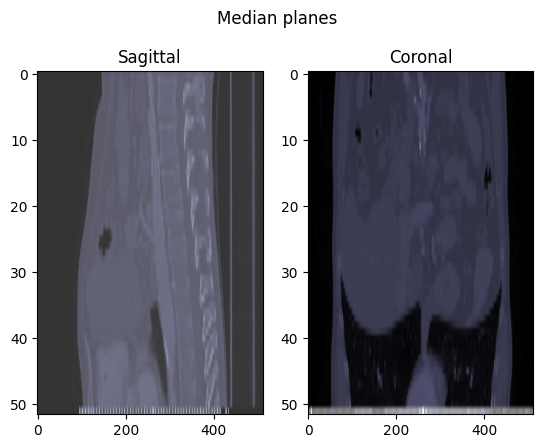

In [396]:
img_dcm = ct_volume #np.flip(ct_volume, axis=0) 
# Show median planes
fig, ax = plt.subplots(1, 2)
ax[0].imshow(utils.median_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=15,alpha=0.8)
ax[0].set_title('Sagittal')
ax[1].imshow(utils.median_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=15)
ax[1].set_title('Coronal')
fig.suptitle('Median planes')
plt.show()

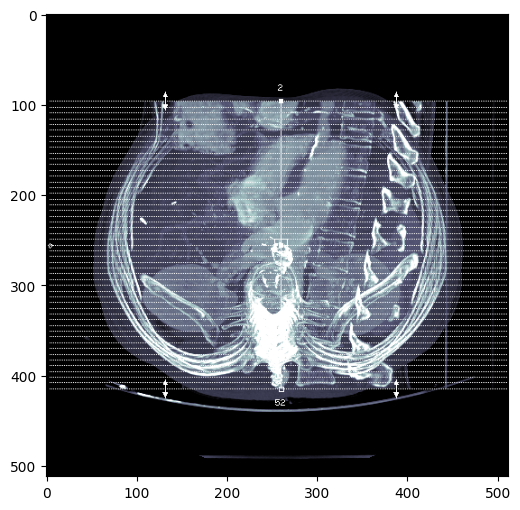

In [397]:
#img_dcm = ct_volume #np.flip(ct_volume, axis=0) 
windowed_img = window_image(img_dcm, center=300, width=900)
mip_img = np.max(windowed_img, axis=0) 
#CLAHE
mip_final = apply_clahe(mip_img)
mask_tumor = np.max(tumor_mask_full, axis=0)
mask_liver = np.max(liver_mask_full, axis=0)
show_mip_with_two_masks(mip_img,mask_liver, mask_tumor, alpha_liver=0.99, alpha_tumor=0.8
                        ,cmap_mip="bone",cmap_liver='Blues', cmap_tumor='Reds',aspect=1)

## GIF

In [33]:
def generate_mip_gif(ct_volume, liver_mask, tumor_mask, output_path="mip_rotation.gif",
                     alpha_liver=0.3, alpha_tumor=0.4,
                     cmap_liver='Blues', cmap_tumor='Reds',
                     cmap_ct='gray', aspect=4, duration=100, steps=36):
    frames = []
    angles = np.linspace(0, 360, steps, endpoint=False)

    for angle in angles:
        fig, ax = plt.subplots(figsize=(5, 5))

        # Rotate volume around the z-axis
        rotated_ct = ndimage.rotate(ct_volume, angle, axes=(1, 2), reshape=False, order=1)
        rotated_liver = ndimage.rotate(liver_mask, angle, axes=(1, 2), reshape=False, order=0)
        rotated_tumor = ndimage.rotate(tumor_mask, angle, axes=(1, 2), reshape=False, order=0)

        # Apply sagittal MIP (axis=2 for X)
        mip_ct = np.max(rotated_ct, axis=1)
        mip_liver = np.max(rotated_liver, axis=1)
        mip_tumor = np.max(rotated_tumor, axis=1)

        # Optional: apply contrast enhancement (e.g., CLAHE or windowing)
        mip_ct_display = mip_ct  # assuming already processed

        # Alpha masks only where mask == 1
        alpha_l = np.where(mip_liver == 1, alpha_liver, 0)
        alpha_t = np.where(mip_tumor == 1, alpha_tumor, 0)

        # Plot base image
        ax.imshow(mip_ct_display, cmap=cmap_ct, aspect=aspect)
        ax.imshow(mip_liver, cmap=cmap_liver, alpha=alpha_l, aspect=aspect)
        ax.imshow(mip_tumor, cmap=cmap_tumor, alpha=alpha_t, aspect=aspect)
        ax.axis('off')

        # Save frame to memory
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        frame = Image.open(buf)
        frames.append(frame.copy())
        plt.close(fig)

    # Save frames to GIF
    frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    print(f"✅ GIF guardado en: {output_path}")

In [14]:
generate_mip_gif(
    ct_volume=windowed_img,             # Volumen ya normalizado y con contraste aplicado
    liver_mask=liver_mask_full,    # Máscara binaria del hígado
    tumor_mask=tumor_mask_full,    # Máscara binaria del tumor
    output_path="mip_liver_tumor2.gif",
    alpha_liver=0.8, alpha_tumor=0.4,
    aspect=5
)

✅ GIF guardado en: mip_liver_tumor2.gif


# Segmentation

In [323]:
def get_component_bbox(component_mask):
    z, y, x = np.where(component_mask > 0)
    return ((z.min(), z.max()), (y.min(), y.max()), (x.min(), x.max()))


def expand_bbox(bbox, shape, margin=2):
    (z_min, z_max), (y_min, y_max), (x_min, x_max) = bbox
    Z, Y, X = shape
    z_min = max(0, z_min - margin)
    z_max = min(Z - 1, z_max + margin)
    y_min = max(0, y_min - margin)
    y_max = min(Y - 1, y_max + margin)
    x_min = max(0, x_min - margin)
    x_max = min(X - 1, x_max + margin)
    return (z_min, z_max), (y_min, y_max), (x_min, x_max)


def compute_mean_intensity(region_mask, volume_crop):
    values = volume_crop[region_mask > 0]
    return np.mean(values) if len(values) > 0 else 0.0


def segment_by_threshold(volume, seed_voxel, intensity_threshold=0.1, reference_intensity=None):
    """
    Segmenta todo el volumen comparando cada voxel con una intensidad de referencia.
    Sin conectividad: incluye cualquier voxel que cumpla con el umbral.

    Parámetros:
    - volume: imagen 3D windowed (float)
    - seed_voxel: (z, y, x)
    - intensity_threshold: diferencia máxima
    - reference_intensity: si None, se usa la intensidad del seed

    Retorna:
    - mask: máscara binaria con voxeles aceptados
    """
    volume = volume.astype(np.float32)
    z, y, x = map(int, seed_voxel)
    ref_val = reference_intensity if reference_intensity is not None else volume[z, y, x]

    diff = np.abs(volume - ref_val)
    mask = (diff <= intensity_threshold).astype(np.uint8)

    return mask

def segment_tumor_region_growing(volume, seed_voxel, intensity_threshold=0.1, reference_intensity=None):
    volume = volume.astype(np.float32)
    seed = tuple(map(int, seed_voxel))
    shape = volume.shape
    z0, y0, x0 = seed
    if not (0 <= z0 < shape[0] and 0 <= y0 < shape[1] and 0 <= x0 < shape[2]):
        raise ValueError(f"Seed voxel {seed} is out of bounds for shape {shape}")

    seed_val = volume[z0, y0, x0]
    ref_val = reference_intensity if reference_intensity is not None else seed_val

    visited = np.zeros(shape, dtype=bool)
    mask = np.zeros(shape, dtype=np.uint8)
    queue = deque([seed])

    while queue:
        z, y, x = queue.popleft()
        if not (0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]):
            continue
        if visited[z, y, x]:
            continue

        visited[z, y, x] = True
        current_val = volume[z, y, x]

        if abs(current_val - ref_val) <= intensity_threshold:
            mask[z, y, x] = 1
            for dz, dy, dx in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                queue.append((z + dz, y + dy, x + dx))

    return mask


def segment_and_separate_close_components(volume, mask_tumor, intensity_threshold=0.1, margin=2, clean=True):
    """
    Segmenta tumores separados individualmente usando region growing limitado a su bounding box
    y elimina posibles fusiones por proximidad entre componentes.

    Parameters:
    - volume: CT windowed (Z,Y,X)
    - mask_tumor: máscara binaria (ground truth)
    - intensity_threshold: umbral de crecimiento
    - margin: voxels extra alrededor del bbox para cada componente
    - clean: si True, aplica binary_opening para separar componentes pegados

    Returns:
    - full_mask: segmentación combinada final
    """
    labeled, n = label(mask_tumor)
    print(f"Detectadas {n} regiones tumorales desconectadas.")

    full_mask = np.zeros_like(volume, dtype=np.uint8)

    for i in range(1, n + 1):
        region = (labeled == i)
        if np.sum(region) == 0:
            continue

        bbox = get_component_bbox(region)
        bbox_exp = expand_bbox(bbox, volume.shape, margin)
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = bbox_exp

        vol_crop = volume[z_min:z_max + 1, y_min:y_max + 1, x_min:x_max + 1]
        region_crop = region[z_min:z_max + 1, y_min:y_max + 1, x_min:x_max + 1]

        seed = tuple(map(int, center_of_mass(region_crop)))
        mean_val = compute_mean_intensity(region_crop, vol_crop)

        # seg_local = segment_by_threshold(
        #     vol_crop,
        #     seed_voxel=seed,
        #     intensity_threshold=intensity_threshold,
        #     reference_intensity=None
        # )
        # seg_local = segment_tumor_region_growing(
        #     vol_crop,
        #     seed_voxel=seed,
        #     intensity_threshold=intensity_threshold,
        #     reference_intensity=None
        # )

        seg_local = binary_closing(seg_local, iterations=2)
        seg_local = binary_fill_holes(seg_local).astype(np.uint8)

        if clean:
            seg_local = binary_opening(seg_local, structure=np.ones((3, 3, 3))).astype(np.uint8)

        full_mask[z_min:z_max + 1, y_min:y_max + 1, x_min:x_max + 1] |= seg_local

    return full_mask


In [324]:
windowed_img2 = window_image(img_dcm, center=400, width=900) # 400,900
#windowed_img2 = window_image_inverted(ct_volume, center=40, width=400)
seg_final = segment_and_separate_close_components(
    volume=windowed_img2,
    mask_tumor=tumor_mask_full,
    intensity_threshold=0.1,
    margin=0,
    clean=False
)

Detectadas 3 regiones tumorales desconectadas.


UnboundLocalError: cannot access local variable 'seg_local' where it is not associated with a value

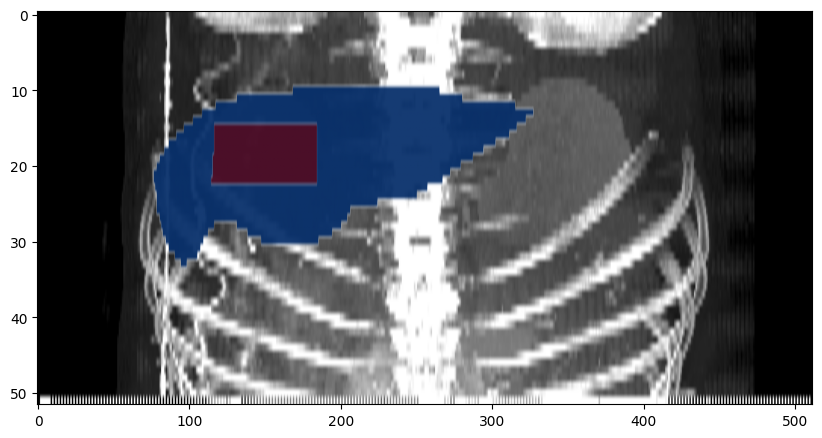

In [409]:
mip_coronal = np.max(windowed_img2, axis=1)
mip_mask_liver = np.max(liver_mask_full, axis=1)
mip_mask_tumor = np.max(seg_final, axis=1)

#axial & axis = 1 coronal & axis = 0 sagittal & axis = 2
show_mip_with_two_masks(
    mip_img=mip_coronal,
    mask_liver=mip_mask_liver,
    mask_tumor=mip_mask_tumor,
    bbox=None,
    centroid=None,
    plane='axial',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=5,
    alpha_liver=0.95 , alpha_tumor=0.7
)

## Metrics

In [37]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2. * intersection / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred) - intersection
    return intersection / (union + 1e-8)

def sensitivity(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn + 1e-8)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp + 1e-8)


In [183]:
y_true = tumor_mask_full.astype(np.uint8)
y_pred = seg_final.astype(np.uint8)


def print_metrics(y_true,y_pred):
    print("Dice:", dice_score(y_true, y_pred))
    print("Jaccard (IoU):", jaccard_index(y_true, y_pred))
    print("Sensitivity:", sensitivity(y_true, y_pred))
    print("Precision:", precision(y_true, y_pred))


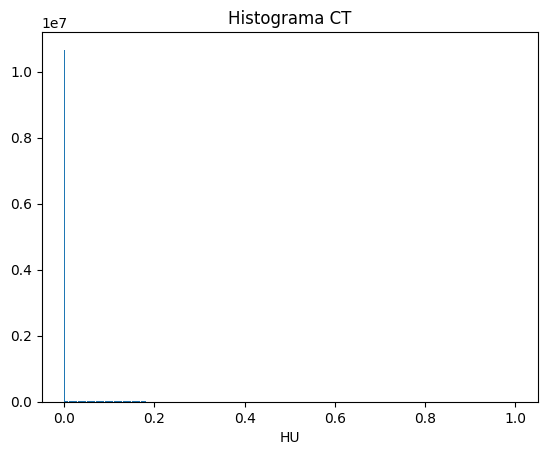

In [82]:
plt.hist(windowed_img2.flatten(), bins=1000)
# plt.xlim(-500, 1000)  # HU típicos para abdomen
plt.title("Histograma CT")
plt.xlabel("HU")
plt.show()

In [334]:
liver_only_mask = (liver_mask_full == 1) & (tumor_mask_full == 0)
tumor_mask = (tumor_mask_full == 1)

# Extraer intensidades
liver_values = windowed_img[liver_only_mask]
tumor_values = windowed_img[tumor_mask]

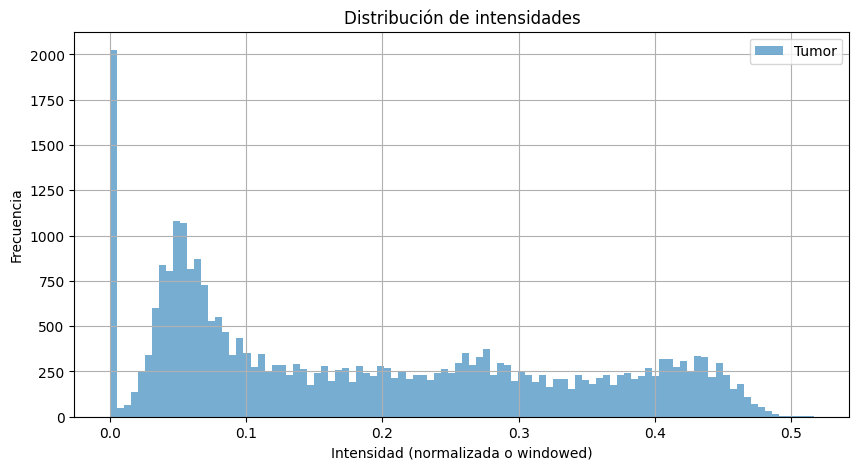

In [335]:
plt.figure(figsize=(10, 5))
# plt.hist(liver_values, bins=100, alpha=0.6, label='Liver (sin tumor)')
plt.hist(tumor_values, bins=100, alpha=0.6, label='Tumor')
plt.title("Distribución de intensidades")
plt.xlabel("Intensidad (normalizada o windowed)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

In [336]:
t_mean = np.mean(tumor_values)
t_std = np.std(tumor_values)

lower = t_mean - 0.5 * t_std
upper = t_mean + 0.5 * t_std    

print(lower, upper)

0.11608215857897115 0.25981132118818717


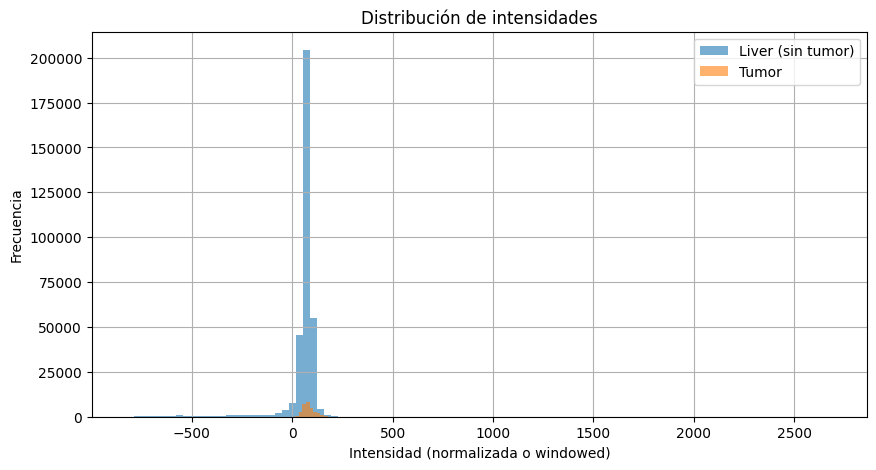

In [337]:
liver_only_mask = (liver_mask_full == 1) & (tumor_mask_full == 0)
tumor_mask = (tumor_mask_full == 1)

# Extraer intensidades
liver_values = ct_volume[liver_only_mask]
tumor_values = ct_volume[tumor_mask]

plt.figure(figsize=(10, 5))
plt.hist(liver_values, bins=100, alpha=0.6, label='Liver (sin tumor)')
plt.hist(tumor_values, bins=100, alpha=0.6, label='Tumor')
plt.title("Distribución de intensidades")
plt.xlabel("Intensidad (normalizada o windowed)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

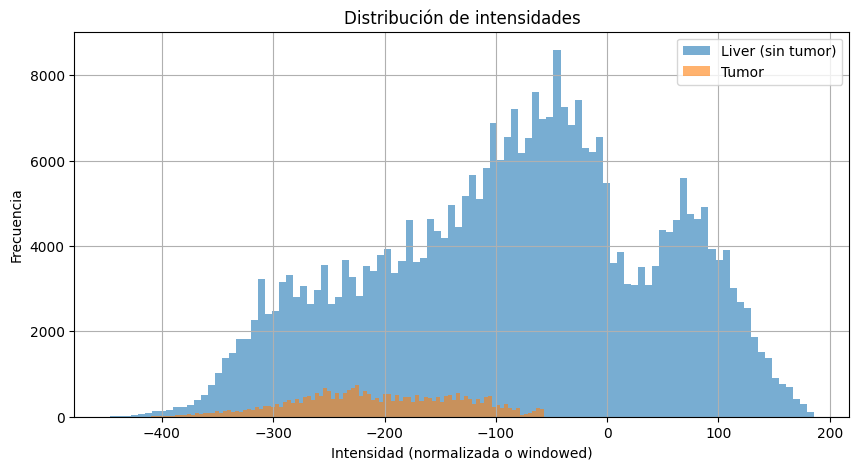

In [339]:
ap

In [ ]:
def liver_zscore(volume, liver_mask):
    liver_vals = volume[liver_mask == 1]
    mean = np.mean(liver_vals)
    std = np.std(liver_vals)
    zmap = (volume - mean) / std
    return zmap

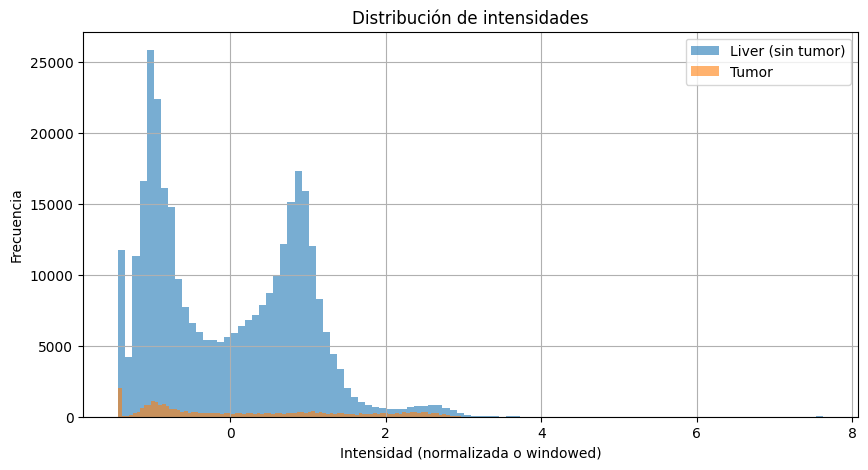

In [340]:
zmap = liver_zscore(windowed_img, liver_mask_full)
#ct_clahe = apply_clahe_3d(windowed_img)
#ct_blurred = gaussian_filter(windowed_img, sigma=1)
# Extraer intensidades
liver_values = zmap[liver_only_mask]
tumor_values = zmap[tumor_mask]

plt.figure(figsize=(10, 5))
plt.hist(liver_values, bins=100, alpha=0.6, label='Liver (sin tumor)')
plt.hist(tumor_values, bins=100, alpha=0.6, label='Tumor')
plt.title("Distribución de intensidades")
plt.xlabel("Intensidad (normalizada o windowed)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

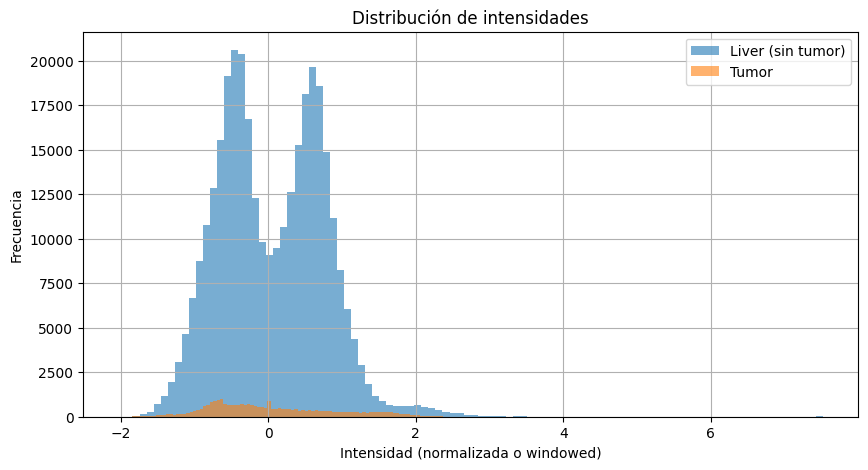

In [341]:
# Mejora el contraste local, luego destaca diferencias con suavizado
# ct_clahe = apply_clahe_3d(windowed_img)
# enhanced = tumor_contrast_enhancement(ct_clahe, liver_mask_full, sigma=1)
ct_z = liver_zscore(windowed_img, liver_mask_full)
enhanced = tumor_contrast_enhancement(ct_z, liver_mask_full, sigma=8)
liver_values = enhanced[liver_only_mask]
tumor_values = enhanced[tumor_mask]

plt.figure(figsize=(10, 5))
plt.hist(liver_values, bins=100, alpha=0.6, label='Liver (sin tumor)')
plt.hist(tumor_values, bins=100, alpha=0.6, label='Tumor')
plt.title("Distribución de intensidades")
plt.xlabel("Intensidad (normalizada o windowed)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

In [360]:
from scipy.ndimage import sobel
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter1d

def gaussian_derivative_3d(volume, sigma=1.0):
    """
    Aplica derivadas del filtro gaussiano en los tres ejes de un volumen 3D.
    
    Retorna:
    - magnitud del gradiente
    """
    gx = gaussian_filter1d(volume, sigma=sigma, axis=2, order=1)
    gy = gaussian_filter1d(volume, sigma=sigma, axis=1, order=1)
    gz = gaussian_filter1d(volume, sigma=sigma, axis=0, order=1)

    gradient_magnitude = np.sqrt(gx**2 + gy**2 + gz**2)
    return gradient_magnitude


def sobel_gradient_magnitude(volume):
    """
    Calcula el gradiente Sobel 3D (módulo) de forma robusta.
    """
    volume = np.nan_to_num(volume, nan=0.0)
    
    gx = sobel(volume, axis=2)
    gy = sobel(volume, axis=1)
    gz = sobel(volume, axis=0)

    # Cuadrado de gradientes
    grad_sq = gx**2 + gy**2 + gz**2
 
    # Reemplaza valores negativos si aparecen por numéricos válidos
    grad_sq[grad_sq < 0] = 0

    magnitude = np.sqrt(grad_sq)
    return magnitude


def laplacian_edges(volume):
    """
    Aplica Laplaciano 3D para resaltar bordes isotrópicos.
    """
    return laplace(volume)

In [ ]:
def get_component_bbox(region_mask):
    z, y, x = np.where(region_mask)
    return ((z.min(), z.max()), (y.min(), y.max()), (x.min(), x.max()))

def analyze_tumor_vs_liver_per_component(volume, tumor_mask, liver_mask, min_voxels=10, k=1.0):
    """
    Para cada componente tumoral:
    - calcula bounding box
    - extrae intensidades de tumor y liver dentro del bbox
    - compara histogramas
    - calcula umbral sugerido (mean ± k·std)
    """
    labeled, n = label(tumor_mask)
    print(f"🔍 Detectadas {n} regiones tumorales desconectadas.")

    all_stats = []

    for i in range(1, n + 1):
        region = (labeled == i)
        if np.sum(region) < min_voxels:
            continue

        bbox = get_component_bbox(region)
        (z0, z1), (y0, y1), (x0, x1) = bbox

        tumor_crop = region[z0:z1+1, y0:y1+1, x0:x1+1]
        liver_crop = liver_mask[z0:z1+1, y0:y1+1, x0:x1+1]
        volume_crop = volume[z0:z1+1, y0:y1+1, x0:x1+1]

        tumor_vals = volume_crop[tumor_crop == 1]
        liver_vals = volume_crop[(tumor_crop == 0) & (liver_crop == 1)]

        if len(tumor_vals) == 0 or len(liver_vals) == 0:
            continue

        t_mean = np.mean(tumor_vals)
        t_std = np.std(tumor_vals)

        threshold_min = t_mean - k * t_std
        threshold_max = t_mean + k * t_std

        stats = {
            'region': i,
            'bbox': bbox,
            'tumor_voxels': len(tumor_vals),
            'liver_voxels': len(liver_vals),
            'tumor_mean': t_mean,
            'liver_mean': np.mean(liver_vals),
            'tumor_std': t_std,
            'liver_std': np.std(liver_vals),
            'threshold_min': threshold_min,
            'threshold_max': threshold_max
        }
        all_stats.append(stats)

        # Comparar histogramas
        plt.figure(figsize=(8, 4))
        plt.hist(liver_vals, bins=50, alpha=0.5, label='Hígado (bbox)')
        plt.hist(tumor_vals, bins=50, alpha=0.5, label='Tumor')
        plt.axvline(threshold_min, color='red', linestyle='--', label=f"min: {threshold_min:.3f}")
        plt.axvline(threshold_max, color='red', linestyle='--', label=f"max: {threshold_max:.3f}")
        plt.title(f"Región #{i} | Tumor vs Hígado (BBox)")
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"🧠 Región #{i}: tumor_mean={t_mean:.3f} ± {k}·std = [{threshold_min:.3f}, {threshold_max:.3f}]")
        print("number of tumor voxels:", stats['tumor_voxels'])
        print("number of liver voxels:", stats['liver_voxels'])
    return all_stats


🔍 Detectadas 3 regiones tumorales desconectadas.


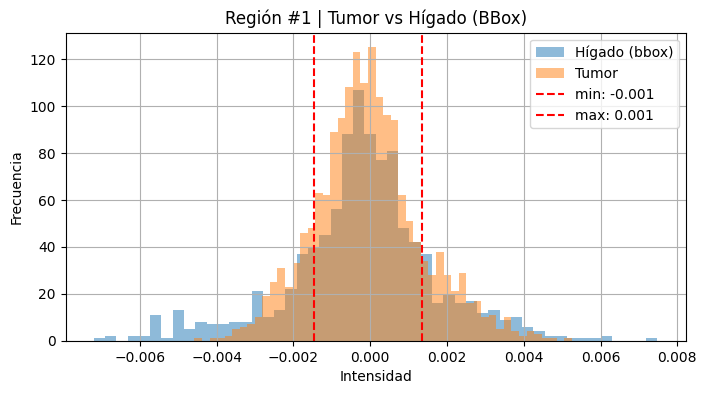

🧠 Región #1: tumor_mean=-0.000 ± 1·std = [-0.001, 0.001]
number of tumor voxels: 1745
number of liver voxels: 1020


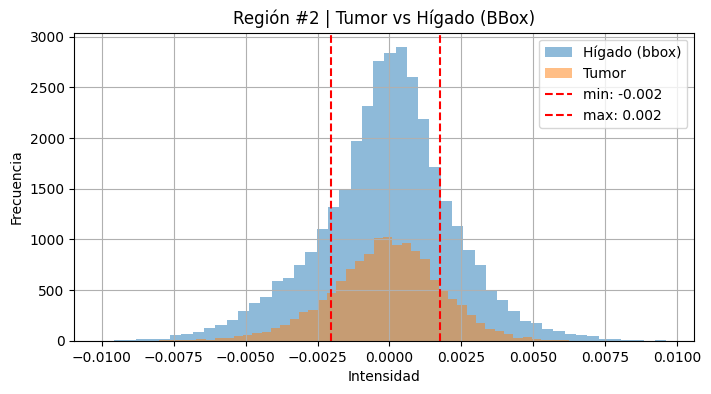

🧠 Región #2: tumor_mean=-0.000 ± 1·std = [-0.002, 0.002]
number of tumor voxels: 13577
number of liver voxels: 34024


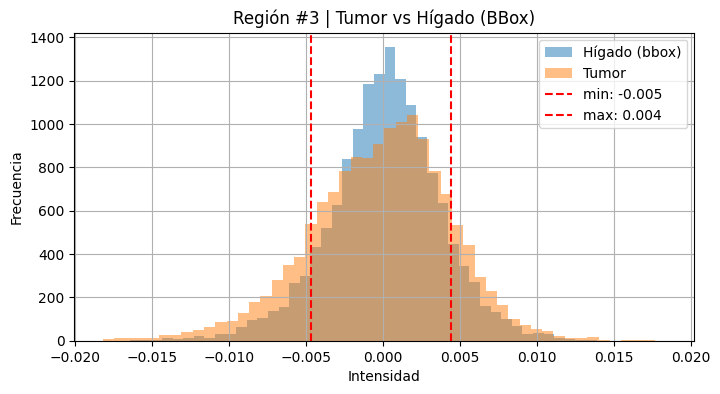

🧠 Región #3: tumor_mean=-0.000 ± 1·std = [-0.005, 0.004]
number of tumor voxels: 14665
number of liver voxels: 14724


In [370]:
 # SOBEL GAUSSIAN SIGMA 20. (windowed_img)
# SOBEL GAUSSIAN SIGMA 2. (windowed_img), tumor 2
# LAPLACE GAUSSIAN SIGMA 2. (windowed_img), tumor 2
#volume_smooth = gaussian_filter(windowed_img, sigma=20)
volume_smooth = gaussian_derivative_3d(windowed_img, sigma=2)
edges_lap = laplacian_edges(volume_smooth)
edges_sobel = sobel_gradient_magnitude(volume_smooth)

stats = analyze_tumor_vs_liver_per_component(ed, tumor_mask_full, liver_mask_full,k=1)

In [326]:
def region_growing_limited_26(volume, seed, min_val, max_val, bbox_shape):
    """
    Region growing 3D con conectividad 26.
    
    Parámetros:
    - volume: volumen 3D (crop)
    - seed: coordenada (z, y, x)
    - min_val, max_val: rango de intensidades permitido
    - bbox_shape: shape del volumen crop
    
    Devuelve:
    - máscara binaria 3D con la región segmentada
    """
    visited = np.zeros(bbox_shape, dtype=bool)
    mask = np.zeros(bbox_shape, dtype=np.uint8)
    queue = deque([seed])

    # Generar todos los vecinos 3D (3x3x3 - centro)
    neighbors = [(dz, dy, dx)
                 for dz in [-1, 0, 1]
                 for dy in [-1, 0, 1]
                 for dx in [-1, 0, 1]
                 if not (dz == 0 and dy == 0 and dx == 0)]

    while queue:
        z, y, x = queue.popleft()
        if not (0 <= z < bbox_shape[0] and 0 <= y < bbox_shape[1] and 0 <= x < bbox_shape[2]):
            continue
        if visited[z, y, x]:
            continue

        visited[z, y, x] = True
        val = volume[z, y, x]

        if min_val <= val <= max_val:
            mask[z, y, x] = 1
            for dz, dy, dx in neighbors:
                queue.append((z + dz, y + dy, x + dx))

    return mask


def region_growing_limited(volume, seed, min_val, max_val, bbox_shape):
    """
    Region growing limitado por valores y volumen local (crop).
    """
    shape = bbox_shape
    visited = np.zeros(shape, dtype=bool)
    mask = np.zeros(shape, dtype=np.uint8)
    queue = deque([seed])

    while queue:
        z, y, x = queue.popleft()
        if not (0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]):
            continue
        if visited[z, y, x]:
            continue

        visited[z, y, x] = True
        val = volume[z, y, x]

        if min_val <= val <= max_val:
            mask[z, y, x] = 1
            for dz, dy, dx in [(-1,0,0), (1,0,0), (0,-1,0), (0,1,0), (0,0,-1), (0,0,1)]:
                queue.append((z+dz, y+dy, x+dx))

    return mask


In [327]:
def segment_tumors_by_stats_and_region_growing(volume, liver_mask, stats, min_voxels=10, only_threshold=False,clean=True):
    """
    Segmenta cada región tumoral según su rango de intensidad.
    - Si `only_threshold=True`, solo aplica umbral
    - Si `False`, aplica region growing desde la región umbral
    Devuelve:
    - máscara binaria global
    - lista de máscaras individuales por componente
    """
    full_mask = np.zeros_like(volume, dtype=np.uint8)
    individual_masks = []

    for region in stats:
        if region['tumor_voxels'] < min_voxels:
            continue

        (z0, z1), (y0, y1), (x0, x1) = region['bbox']
        crop = volume[z0:z1+1, y0:y1+1, x0:x1+1]
        crop_liver = liver_mask[z0:z1+1, y0:y1+1, x0:x1+1]

        min_val = region['threshold_min']
        max_val = region['threshold_max']

        candidate_mask = ((crop >= min_val) & (crop <= max_val) & (crop_liver == 1)).astype(np.uint8)

        if only_threshold:
            seg_local = candidate_mask
        else:
            # Buscar seed desde la mayor región candidata
            labeled, n = label(candidate_mask)
            if n == 0:
                continue

            largest_region = np.argmax([np.sum(labeled == i) for i in range(1, n+1)]) + 1
            seed_voxels = np.argwhere(labeled == largest_region)
            if seed_voxels.size == 0:
                continue

            seed = tuple(seed_voxels[len(seed_voxels)//2])  # centro aproximado

            seg_local = region_growing_limited_26(
                crop, seed,
                min_val=min_val,
                max_val=max_val,
                bbox_shape=crop.shape
            )

        # Aquí entra el POSPROCESADO (aplica a ambas ramas)
        seg_local = binary_closing(seg_local, iterations=2)
        seg_local = binary_fill_holes(seg_local).astype(np.uint8)

        if clean:
            seg_local = binary_opening(seg_local, structure=np.ones((3, 3, 3))).astype(np.uint8)

        # Añadir al volumen final y guardar individualmente
        full_mask[z0:z1+1, y0:y1+1, x0:x1+1] |= seg_local
        individual = np.zeros_like(volume, dtype=np.uint8)
        individual[z0:z1+1, y0:y1+1, x0:x1+1] = seg_local
        individual_masks.append(individual)


    return full_mask, individual_masks


In [352]:
seg_final,individuals = segment_tumors_by_stats_and_region_growing(
    volume=edges_lap,
    liver_mask=liver_mask_full,
    stats=stats,
    min_voxels=20,
    only_threshold=False,
    clean=False
)


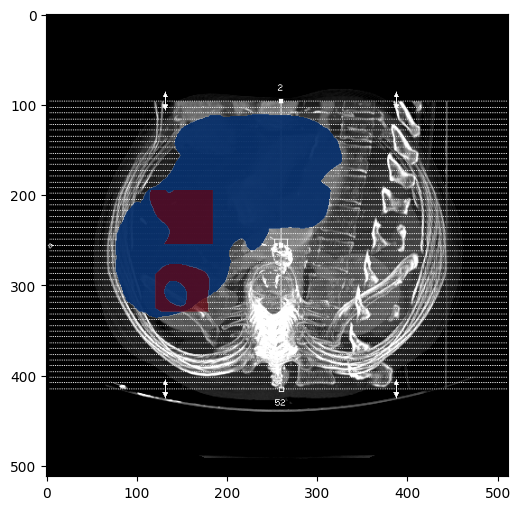

In [353]:
mip_coronal = np.max(windowed_img2, axis=0)
mip_mask_liver = np.max(liver_mask_full, axis=0)
mip_mask_tumor = np.max(seg_final, axis=0)

#axial & axis = 1 coronal & axis = 0 sagittal & axis = 2
show_mip_with_two_masks(
    mip_img=mip_coronal,
    mask_liver=mip_mask_liver,
    mask_tumor=mip_mask_tumor,
    bbox=None,
    centroid=None,
    plane='coronal',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=1,
    alpha_liver=0.95 , alpha_tumor=0.7
)

In [354]:
y_true = tumor_mask_full.astype(np.uint8)
y_pred = seg_final.astype(np.uint8)
print_metrics(y_true,y_pred)

Dice: 0.434285506217264
Jaccard (IoU): 0.2773720930231913
Sensitivity: 0.3977390202419723
Precision: 0.4782277465916286


In [375]:
from skimage.segmentation import watershed

def get_centroid(mask):
    coords = np.argwhere(mask)
    return tuple(np.mean(coords, axis=0).astype(int))

def watershed_by_component(volume, tumor_mask, liver_mask, sigma=1.5, min_voxels=10):
    """
    Aplica watershed localmente por cada componente tumoral.
    Devuelve una máscara global con las segmentaciones combinadas.
    """
    labeled, n = label(tumor_mask)
    print(f"🔍 Detectadas {n} regiones tumorales desconectadas.")
    
    full_mask = np.zeros_like(volume, dtype=np.uint8)

    for i in range(1, n + 1):
        region = (labeled == i)
        if np.sum(region) < min_voxels:
            continue

        bbox = get_component_bbox(region)
        (z0, z1), (y0, y1), (x0, x1) = bbox

        crop_vol = volume[z0:z1+1, y0:y1+1, x0:x1+1]
        crop_liver = liver_mask[z0:z1+1, y0:y1+1, x0:x1+1]
        crop_region = region[z0:z1+1, y0:y1+1, x0:x1+1]

        edge_map = gaussian_derivative_3d(crop_vol, sigma=sigma)

        # Crear marcadores
        markers = np.zeros_like(crop_vol, dtype=np.int32)

        centroid = get_centroid(crop_region)
        cz, cy, cx = [int(c) - o for c, o in zip(centroid, [z0, y0, x0])]
        if not (0 <= cz < crop_vol.shape[0] and 0 <= cy < crop_vol.shape[1] and 0 <= cx < crop_vol.shape[2]):
            continue  # seed fuera de límites
        markers[cz, cy, cx] = 1

        markers[crop_liver == 0] = 2  # marcador fondo

        labels = watershed(edge_map, markers)
        seg_local = (labels == 1).astype(np.uint8)

        # Insertar en volumen global
        full_mask[z0:z1+1, y0:y1+1, x0:x1+1] |= seg_local

    return full_mask

tumor_ws = watershed_by_component(
    volume=windowed_img,
    tumor_mask=tumor_mask_full,
    liver_mask=liver_mask_full,
    sigma=10
)

🔍 Detectadas 3 regiones tumorales desconectadas.


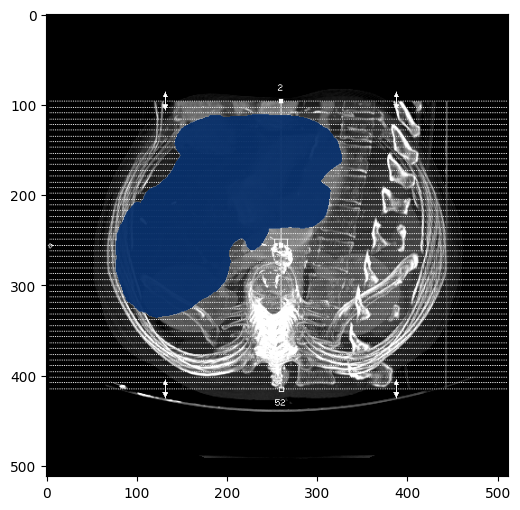

Dice: 0.0
Jaccard (IoU): 0.0
Sensitivity: 0.0
Precision: 0.0


In [376]:
mip_ws_t= np.max(tumor_ws, axis=0)
show_mip_with_two_masks(
    mip_img=mip_coronal,
    mask_liver=mip_mask_liver,
    mask_tumor=mip_ws_t,
    bbox=None,
    centroid=None,
    plane='coronal',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=1,
    alpha_liver=0.95 , alpha_tumor=0.7
)

y_true = tumor_mask_full.astype(np.uint8)
y_pred = mip_ws_t.astype(np.uint8)
print_metrics(y_true,y_pred)

In [377]:
if np.all(liver_mask_full[tumor_mask_full == 1] == 1):
    print("✅ Todos los vóxeles marcados como tumor están dentro del hígado.")
else:
    print("❌ Hay vóxeles tumorales fuera del hígado.")
    # Opcional: contar cuántos
    n_out = np.sum((tumor_mask_full == 1) & (liver_mask_full == 0))
    print(f"🔍 Tumor fuera del hígado: {n_out} vóxeles")


❌ Hay vóxeles tumorales fuera del hígado.
🔍 Tumor fuera del hígado: 367 vóxeles


In [404]:


def plot_slices_with_two_masks(volume, mask1=None, mask2=None,
                                cmap1='Blues', cmap2='Reds',
                                alpha1=0.3, alpha2=0.4,
                                save_path=None, max_slices=100):
    z_slices = volume.shape[0]
    step = max(1, z_slices // max_slices)
    selected_slices = range(0, z_slices, step)

    ncols = 6
    nrows = int(np.ceil(len(selected_slices) / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()

    for ax in axs:
        ax.axis('off')

    for i, z in enumerate(selected_slices):
        ax = axs[i]
        ax.imshow(volume[z], cmap='gray')

        if mask1 is not None:
            alpha_mask1 = np.where(mask1[z] == 1, alpha1, 0)
            ax.imshow(mask1[z], cmap=cmap1, alpha=alpha_mask1)

        if mask2 is not None:
            alpha_mask2 = np.where(mask2[z] == 1, alpha2, 0)
            ax.imshow(mask2[z], cmap=cmap2, alpha=alpha_mask2)

        ax.set_title(f"Slice {z}")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"✅ Imagen guardada en {save_path}")
        plt.close()
    else:
        plt.show()


In [414]:
plot_slices_with_two_masks(
    volume=windowed_img,
    mask1=liver_mask_full,
    mask2=tumor_mask_full,
    cmap1='Blues',
    cmap2='Reds',
    alpha1=0.8,
    alpha2=0.8,
    save_path="overlay_liver_tumor3.png"
)

✅ Imagen guardada en overlay_liver_tumor3.png
